In [1]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series")

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

In [3]:
with open('data/pv.pickle', 'rb') as f:
    pv = pickle.load(f)

# scaling

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()
scaler.fit(pv[['power']])

MinMaxScaler()

In [12]:
pv['power_scale'] = scaler.transform(pv[['power']])

In [36]:
pv = pv.set_index('datetime')

In [42]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,12,30,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,31,00,tzinfo=tz):]

# data loader

- torch 에서 LSTM 의 경우 
  - input: (seq_len, batch, input_size)
  - output: (seq_len, batch, num_directions * hidden_size) 

In [16]:
from torch.utils.data import DataLoader, Dataset

In [17]:
class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        # seq_len
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2)) # (seq_len, input_window, feature)
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2)) # (seq_len, output_window, feature)
        self.x = X
        self.y = Y
        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return self.len

In [54]:
iw = 24*7
ow = 24

train_dataset = windowDataset(pv_train['power_scale'], input_window=iw, output_window=ow, stride=24)
train_loader = DataLoader(train_dataset, batch_size=16)

# test_dataset = windowDataset(pv_test['power_scale'], input_window=iw, output_window=ow, stride=10)
# test_loader = DataLoader(test_dataset, batch_size=24)

In [55]:
len(train_loader)

23

# model

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [57]:
class lstm(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(lstm, self).__init__() 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # batch_first=True 인 경우 (batch, input_window, feature) 에 맞춰서 input
        self.lstm_encoder = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True) 
        self.lstm_decoder = nn.LSTM(input_size)

    def forward(self, x):
        lstm_out, hidden = self.lstm(x)


In [58]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

In [59]:
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)
        
        return output, self.hidden

In [60]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        #원하는 길이가 될 때까지 decoder를 실행한다.
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            
            # teacher forcing을 구현한다.
            # teacher forcing에 해당하면 다음 인풋값으로는 예측한 값이 아니라 실제 값을 사용한다.
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs
	
    # 편의성을 위해 예측해주는 함수도 생성한다.
    def predict(self, inputs, target_len):
        self.eval()
        inputs = inputs.unsqueeze(0)
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

In [89]:
device='cuda'
model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)

In [90]:
learning_rate=0.01
epoch = 1000
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [91]:
from tqdm.auto import tqdm
import random

In [92]:
model.train()

pbar = tqdm(range(epoch))
for i in pbar:
    total_loss = 0.0
    for x,y in train_loader:
        optimizer.zero_grad()
        x = x.to(device).float()
        y = y.to(device).float()
        output = model(x, y, ow, 0.6).to(device)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.cpu().item()
    pbar.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [93]:
predict = model.predict(torch.tensor(pv_train[-24*7:]['power_scale']).reshape(-1,1).to(device).float(), target_len=ow)
real = np.array(pv_test['power_scale'])

predict = scaler.inverse_transform(predict.reshape(-1,1))
real = scaler.inverse_transform(real.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


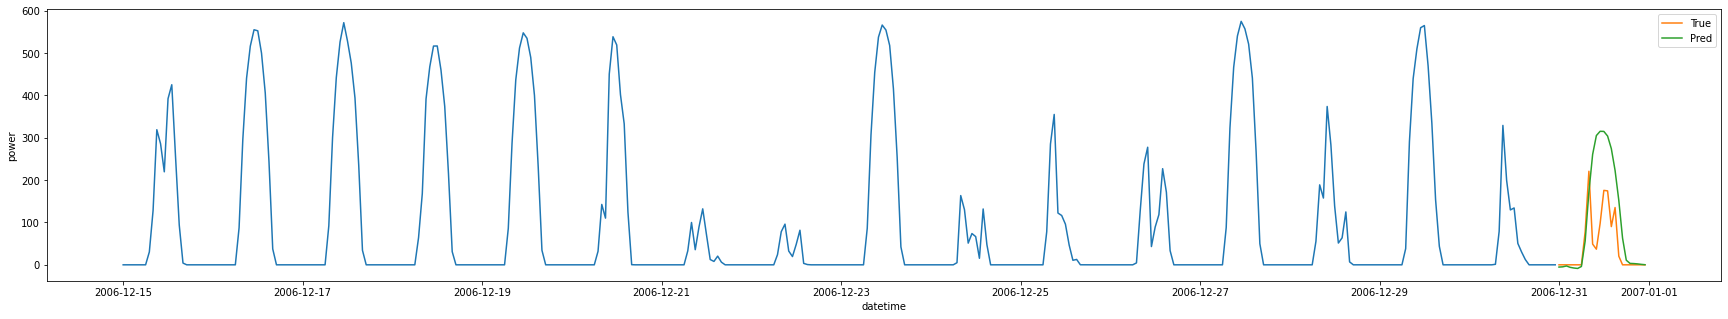

In [99]:
import seaborn as sns

plt.figure(figsize=(30,5))
sns.lineplot(pv_train.loc[datetime(2006,12,15,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,15,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, real.reshape(-1), label='True')
sns.lineplot(pv_test.index, predict.reshape(-1), label='Pred')
plt.legend()